In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data_df = pd.read_excel('data/time_series_375_prerpocess.xlsx', encoding='gbk', index_col=[0])
print(train_data_df.shape)
test_data_df = pd.read_excel('data/time_series_test_110_preprocess.xlsx', encoding='gbk', index_col=[0])
print(test_data_df.shape)

(6120, 80)
(757, 7)


In [13]:
columns=train_data_df.columns.values.tolist()[6:]
for i in columns:
    print(i+',',end="")

高敏心肌肌钙蛋白I,血红蛋白,氯,凝血酶原时间,降钙素原,嗜酸细胞(%),白细胞介素2受体,碱性磷酸酶,白蛋白,嗜碱细胞(%),白细胞介素10,总胆红素,血小板计数,单核细胞(%),抗凝血酶,白细胞介素8,间接胆红素,RBC分布宽度CV,中性粒细胞(%),总蛋白,梅毒螺旋体抗体定量,凝血酶原活动度,乙肝表面抗原定量,平均RBC体积,红细胞压积,白细胞计数,肿瘤坏死因子α,平均血红蛋白浓度,纤维蛋白原,白细胞介素1β,尿素,淋巴细胞(#),酸碱度,红细胞计数,嗜酸细胞(#),校正钙,钾,葡萄糖,中性粒细胞(#),直接胆红素,平均PLT体积,铁蛋白,RBC分布宽度SD,凝血酶时间,淋巴细胞(%),丙肝抗体定量,D-D二聚体定量,总胆固醇,谷草转氨酶,尿酸,碳酸氢根,钙,氨基末端脑钠肽前体（NT-proBNP）,乳酸脱氢酶,大血小板比率,白细胞介素6,纤维蛋白(原)降解产物,单核细胞(#),PLT分布宽度,球蛋白,γ-谷氨酰转肽酶,国际标准化比值,嗜碱细胞(#),2019-nCoV核酸检测,平均血红蛋白含量,活化部分凝血活酶时间,超敏C反应蛋白,HIV抗体定量,钠,血小板压积,血沉,谷丙转氨酶,eGFR(基于CKD-EPI方程),肌酐,

### data selection

In [2]:
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

def read_data_cn(fname, interval, forecast):
    """
    interval: interval of group data, days
    forecast: whether the patient will die within the next forecast hours
    """

    # read data
    data_df = pd.read_excel(fname, encoding='gbk', index_col=[0])
    # group by interval
    data_df['total_period'] = data_df['出院时间'] - data_df['入院时间']
    data_df['total_period'] = data_df['total_period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['出院时间'] - data_df['RE_DATE']
    data_df['period'] = data_df['period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['total_period'] - data_df['period']
    data_df = data_df.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make outcome
    decease = data_df['出院方式'].values # whether the patient will die in hospital
    data_df['decease'] = decease
    decompensation = data_df['出院时间'] - data_df['RE_DATE'] # whether the patient will die within the next 24 hours
    decompensation = decompensation.apply(lambda x: int(x.total_seconds()/3600 < forecast))
    data_df['decompensation'] = data_df['decease'] * decompensation
    # make it cleaner
    data_df = data_df.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)
    columns = ['PATIENT_ID', 'period','decease', 'decompensation', '乳酸脱氢酶', '超敏C反应蛋白', '淋巴细胞(%)']
    data_df = data_df[columns]
    return data_df

In [8]:
interval = 3
forecast = 72
df_train = read_data_cn('data/time_series_375_prerpocess.xlsx', interval, forecast)
df_test = read_data_cn('data/time_series_test_110_preprocess.xlsx', interval, forecast)

# interpolate
df_train = df_train.interpolate(method='linear').ffill().bfill() 
df_test = df_test.interpolate(method='linear').ffill().bfill() 

In [5]:
df_train

,PATIENT_ID,period,decease,decompensation,乳酸脱氢酶,超敏C反应蛋白,淋巴细胞(%)
0,1.0,0.0,0.0,0.0,306.0,43.10,22.600000
1,1.0,1.0,0.0,0.0,278.0,23.35,24.250000
2,1.0,2.0,0.0,0.0,250.0,3.60,25.900000
3,1.0,3.0,0.0,0.0,200.0,3.10,10.500000
4,1.0,5.0,0.0,0.0,206.0,2.60,25.900000
...,...,...,...,...,...,...,...
1162,374.0,1.0,1.0,1.0,1867.0,61.70,2.300000
1163,375.0,0.0,1.0,0.0,915.0,58.50,9.900000
1164,375.0,1.0,1.0,0.0,1083.5,128.00,8.833333
1165,375.0,2.0,1.0,0.0,1252.0,197.50,7.766667


### create batch data by same length

In [359]:
def creat_batch_data(raw_data,outfile):
    
    index=raw_data.groupby(['PATIENT_ID'])['decease'].count()
    index=index.sort_values().reset_index()# sort
    index.columns = ['PATIENT_ID', 'time_length']
    index.head()
    time_length_count = index.groupby(['time_length'])['PATIENT_ID'].count().reset_index()
    time_length_count.columns=['time_length','count']
    time_length_count.head()
    
    batches=[]
    labels=[]
    intervals=[]
    for length in time_length_count['time_length']:
        PID_series=index[index['time_length']==length]['PATIENT_ID'].tolist()
        batch=[]
        label=[]
        interval=[]
        n=0
        for j in PID_series:
            temp = raw_data[raw_data['PATIENT_ID']==j]
            if temp['decease'].sum()==0:
                label.append([1,0]) # survival[1,0] die[0,1]
            else:
                label.append([0,1])
            features=temp.iloc[:,4:7].values.tolist() # 3 features
            batch.append(features)
            time=temp.iloc[:,1].values.tolist() # time interval
            interval.append(time)
            n+=1
            if n%256==0: # max 256 for a batch
                batches.append(batch)
                labels.append(label)
                batch=[]
                label=[]
        batches.append(batch)
        labels.append(label)
        intervals.append(interval)
    pickle.dump(batches, open('BatchData/' +outfile+ 'Data.seqs', 'wb'), -1) 
    pickle.dump(labels, open('BatchData/' +outfile+ 'Label.seqs', 'wb'), -1) 
    pickle.dump(intervals, open('BatchData/' +outfile+ 'Interval.seqs', 'wb'), -1) 

In [12]:
creat_batch_data(df_train,'Train')
creat_batch_data(df_test,'Test')

In [13]:
path_string = 'BatchData/TestData.seqs'
with open(path_string,'rb') as f:
    a = pickle.load(f)

In [14]:
a[0]

[[[195.0, 0.9, 35.5]],
 [[248.0, 1.4, 19.6]],
 [[178.0, 0.9, 35.8]],
 [[166.0, 1.6, 39.2]],
 [[342.0, 2.9, 11.0]],
 [[181.0, 16.6, 23.9]],
 [[178.0, 1.0, 48.1]],
 [[186.0, 1.6, 23.2]]]

In [ ]:
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

def read_data_cn(fname, interval, forecast):
    """
    interval: interval of group data, days
    forecast: whether the patient will die within the next forecast hours
    """

    # read data
    data_df = pd.read_excel(fname, encoding='gbk', index_col=[0])
    # group by interval
    data_df['total_period'] = data_df['出院时间'] - data_df['入院时间']
    data_df['total_period'] = data_df['total_period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['出院时间'] - data_df['RE_DATE']
    data_df['period'] = data_df['period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['total_period'] - data_df['period']
    data_df = data_df.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make outcome
    decease = data_df['出院方式'].values # whether the patient will die in hospital
    data_df['decease'] = decease
    decompensation = data_df['出院时间'] - data_df['RE_DATE'] # whether the patient will die within the next 24 hours
    decompensation = decompensation.apply(lambda x: int(x.total_seconds()/3600 < forecast))
    data_df['decompensation'] = data_df['decease'] * decompensation
    # make it cleaner
    data_df = data_df.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)
    columns = ['PATIENT_ID', 'period','decease', 'decompensation', '乳酸脱氢酶', '超敏C反应蛋白', '淋巴细胞(%)']
    data_df = data_df[columns]
    return data_df

### dataset statistics

#### missing rate

In [212]:
data_df = pd.read_excel('data/time_series_375_prerpocess.xlsx', encoding='gbk', index_col=[0])

In [26]:
# sample length count
count=data_df.groupby(['PATIENT_ID'])['RE_DATE'].count().reset_index()
sum_count=count.groupby(['RE_DATE']).count().reset_index()
sample_length=sum_count['RE_DATE'].tolist()
sample_length_count=sum_count['PATIENT_ID'].tolist()

In [40]:
# average length
total=0.0
counts=0.0
for i in range(len(sample_length)):
    total=total+sample_length[i]*sample_length_count[i]
    counts=counts+sample_length_count[i]
print(total/counts,total)

16.282666666666668 6106.0


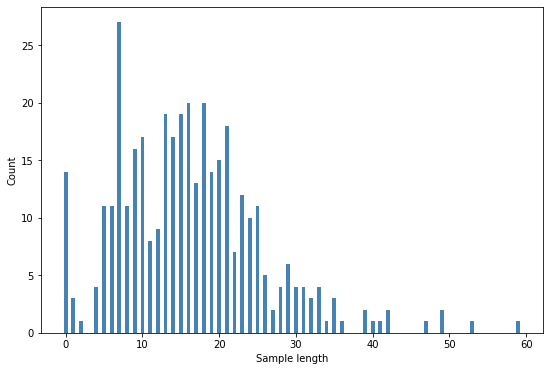

In [36]:
plt.figure(figsize=(9,6))
plt.bar(sample_length,sample_length_count, width=0.5 , color='steelblue')
plt.ylabel('Count')
plt.xlabel('Sample length')
plt.savefig('sample_length.jpg', dpi=300)
plt.show()

In [204]:
# missing rate
def missing_rate(data_df):
    missing_count=0.0
    for index, row in data_df.iterrows():
        for i in range(2,76):
            if(np.isnan(row[i])):
                missing_count=missing_count+1
    missing_rate=   missing_count / (data_df.shape[0]*74)
    return missing_rate

# group by interval 
def read_data_with_interval(interval,data_df,o_columns):
    # group by interval
    a=data_df
    a['total_period'] = a['出院时间'] - a['入院时间']
    a['total_period'] = a['total_period'].apply(lambda x: x.days//interval)
    a['period'] = a['出院时间'] - a['RE_DATE']
    a['period'] = a['period'].apply(lambda x: x.days//interval)
    a['period'] = a['total_period'] - a['period']
    a = a.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make it cleaner
    a = a.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    columns = ['PATIENT_ID', 'period']
    columns.extend(o_columns)
    a = a[columns]
    return a

In [213]:
o_columns=data_df.columns.values.tolist()[6:]
mrs=[]
for i in range(1,8):
    df=read_data_with_interval(i,data_df,o_columns)
    mr=missing_rate(df)
    mrs.append(mr)

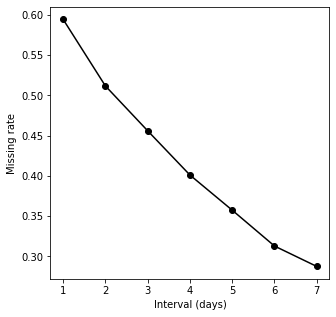

In [219]:
x=[1,2,3,4,5,6,7]
plt.figure(figsize=(5,5))
plt.plot(x,mrs,c='black',marker='o')
plt.xlabel('Interval (days)')
plt.ylabel('Missing rate')
#plt.gca().set_ylim(0,1)
plt.savefig('missing_rate.jpg', dpi=300)

#### feature selection

In [270]:
data_df = pd.read_excel('data/time_series_375_prerpocess.xlsx', encoding='gbk', index_col=[0])

In [237]:
missing_count=[0.0]*74
for index, row in data_df.iterrows():
    for i in range(6,80):
        if(np.isnan(row[i])):
            missing_count[i-6]=missing_count[i-6]+1
feature_missing_rate=  [a/data_df.shape[0] for a in missing_count]

In [238]:
o_columns=data_df.columns.values.tolist()[6:]
feature_missing_rate_df = pd.DataFrame(columns =o_columns)
feature_missing_rate_df.loc[0]= feature_missing_rate

In [241]:
feature_missing_rate_df

,高敏心肌肌钙蛋白I,血红蛋白,氯,凝血酶原时间,降钙素原,嗜酸细胞(%),白细胞介素2受体,碱性磷酸酶,白蛋白,嗜碱细胞(%),白细胞介素10,总胆红素,血小板计数,单核细胞(%),抗凝血酶,白细胞介素8,间接胆红素,RBC分布宽度CV,中性粒细胞(%),总蛋白,梅毒螺旋体抗体定量,凝血酶原活动度,乙肝表面抗原定量,平均RBC体积,红细胞压积,白细胞计数,肿瘤坏死因子α,平均血红蛋白浓度,纤维蛋白原,白细胞介素1β,尿素,淋巴细胞(#),酸碱度,红细胞计数,嗜酸细胞(#),校正钙,钾,葡萄糖,中性粒细胞(#),直接胆红素,平均PLT体积,铁蛋白,RBC分布宽度SD,凝血酶时间,淋巴细胞(%),丙肝抗体定量,D-D二聚体定量,总胆固醇,谷草转氨酶,尿酸,碳酸氢根,钙,氨基末端脑钠肽前体（NT-proBNP）,乳酸脱氢酶,大血小板比率,白细胞介素6,纤维蛋白(原)降解产物,单核细胞(#),PLT分布宽度,球蛋白,γ-谷氨酰转肽酶,国际标准化比值,嗜碱细胞(#),2019-nCoV核酸检测,平均血红蛋白含量,活化部分凝血活酶时间,超敏C反应蛋白,HIV抗体定量,钠,血小板压积,血沉,谷丙转氨酶,eGFR(基于CKD-EPI方程),肌酐
0,0.917157,0.840686,0.840686,0.89183,0.925,0.843627,0.956209,0.848039,0.847386,0.843627,0.956373,0.848039,0.843627,0.843464,0.946078,0.956209,0.851961,0.849183,0.843627,0.847876,0.954412,0.89232,0.954412,0.843627,0.843627,0.81585,0.956209,0.843627,0.907516,0.956209,0.847059,0.843627,0.937255,0.81585,0.843627,0.850654,0.839869,0.873366,0.843627,0.848039,0.85915,0.953758,0.849183,0.907516,0.843464,0.954412,0.897059,0.847876,0.847222,0.847386,0.847386,0.840033,0.922386,0.847386,0.85915,0.955556,0.946078,0.843627,0.85915,0.848039,0.848039,0.89232,0.843627,0.918137,0.843627,0.90719,0.879575,0.954575,0.840686,0.85915,0.937418,0.847876,0.847059,0.847059


In [250]:
def feature_missing_rate_byinterval(df):
    missing_count=[0.0]*74
    for index, row in df.iterrows():
        for i in range(2,76):
            if(np.isnan(row[i])):
                missing_count[i-2]=missing_count[i-2]+1
    feature_missing_rate=  [a/df.shape[0] for a in missing_count]
    return feature_missing_rate

In [266]:
# interval day1 -day8
o_columns=data_df.columns.values.tolist()[6:]
fmrs=[]
for i in range(1,8):
    df=read_data_with_interval(i,data_df,o_columns)
    mr=feature_missing_rate_byinterval(df)
    fmrs.append(mr)
feature_missing_rate.extend(fmrs)

In [274]:
o_columns=data_df.columns.values.tolist()[6:]
feature_missing_rate_df = pd.DataFrame(columns =o_columns)
for i in range(len(fmr)): feature_missing_rate_df.loc[i]= feature_missing_rate[i]

In [275]:
feature_missing_rate_df

,高敏心肌肌钙蛋白I,血红蛋白,氯,凝血酶原时间,降钙素原,嗜酸细胞(%),白细胞介素2受体,碱性磷酸酶,白蛋白,嗜碱细胞(%),白细胞介素10,总胆红素,血小板计数,单核细胞(%),抗凝血酶,白细胞介素8,间接胆红素,RBC分布宽度CV,中性粒细胞(%),总蛋白,梅毒螺旋体抗体定量,凝血酶原活动度,乙肝表面抗原定量,平均RBC体积,红细胞压积,白细胞计数,肿瘤坏死因子α,平均血红蛋白浓度,纤维蛋白原,白细胞介素1β,尿素,淋巴细胞(#),酸碱度,红细胞计数,嗜酸细胞(#),校正钙,钾,葡萄糖,中性粒细胞(#),直接胆红素,平均PLT体积,铁蛋白,RBC分布宽度SD,凝血酶时间,淋巴细胞(%),丙肝抗体定量,D-D二聚体定量,总胆固醇,谷草转氨酶,尿酸,碳酸氢根,钙,氨基末端脑钠肽前体（NT-proBNP）,乳酸脱氢酶,大血小板比率,白细胞介素6,纤维蛋白(原)降解产物,单核细胞(#),PLT分布宽度,球蛋白,γ-谷氨酰转肽酶,国际标准化比值,嗜碱细胞(#),2019-nCoV核酸检测,平均血红蛋白含量,活化部分凝血活酶时间,超敏C反应蛋白,HIV抗体定量,钠,血小板压积,血沉,谷丙转氨酶,eGFR(基于CKD-EPI方程),肌酐
0,0.917157,0.840686,0.840686,0.891830,0.925000,0.843627,0.956209,0.848039,0.847386,0.843627,0.956373,0.848039,0.843627,0.843464,0.946078,0.956209,0.851961,0.849183,0.843627,0.847876,0.954412,0.892320,0.954412,0.843627,0.843627,0.815850,0.956209,0.843627,0.907516,0.956209,0.847059,0.843627,0.937255,0.815850,0.843627,0.850654,0.839869,0.873366,0.843627,0.848039,0.859150,0.953758,0.849183,0.907516,0.843464,0.954412,0.897059,0.847876,0.847222,0.847386,0.847386,0.840033,0.922386,0.847386,0.859150,0.955556,0.946078,0.843627,0.859150,0.848039,0.848039,0.892320,0.843627,0.918137,0.843627,0.907190,0.879575,0.954575,0.840686,0.859150,0.937418,0.847876,0.847059,0.847059
1,0.727071,0.481379,0.480823,0.641467,0.745414,0.483046,0.854364,0.497499,0.495275,0.483046,0.854919,0.497499,0.483046,0.482490,0.822123,0.854364,0.509728,0.501390,0.483046,0.497499,0.844914,0.643135,0.844914,0.483046,0.483046,0.433018,0.854364,0.483046,0.694275,0.854364,0.495831,0.483046,0.804892,0.433018,0.483046,0.506392,0.479155,0.578099,0.483046,0.497499,0.530850,0.844358,0.501390,0.694275,0.482490,0.844914,0.657032,0.496943,0.496943,0.496943,0.496943,0.478599,0.742635,0.497499,0.530850,0.852140,0.822123,0.483046,0.530850,0.497499,0.497499,0.643135,0.483046,0.735409,0.483046,0.693719,0.601445,0.845470,0.480823,0.530850,0.787104,0.496943,0.495831,0.495831
2,0.673601,0.380201,0.388092,0.562410,0.678623,0.380918,0.813486,0.398135,0.395983,0.380918,0.814204,0.398135,0.380918,0.380201,0.784792,0.813486,0.411765,0.402439,0.380918,0.398135,0.800574,0.563845,0.800574,0.380918,0.380918,0.342181,0.813486,0.380918,0.629842,0.813486,0.401722,0.380918,0.761836,0.342181,0.380918,0.408178,0.385940,0.487805,0.380918,0.398135,0.427547,0.799857,0.402439,0.629842,0.380201,0.800574,0.580344,0.397418,0.397418,0.403156,0.403156,0.385940,0.695122,0.398135,0.427547,0.810617,0.784792,0.380918,0.427547,0.398135,0.398135,0.563845,0.380918,0.674319,0.380918,0.629842,0.507891,0.801291,0.388092,0.427547,0.726686,0.397418,0.401722,0.401722
3,0.641817,0.321337,0.321337,0.504713,0.628106,0.321337,0.780634,0.329049,0.326478,0.321337,0.781491,0.329049,0.321337,0.321337,0.759212,0.780634,0.347044,0.347901,0.321337,0.329049,0.762639,0.505570,0.762639,0.321337,0.321337,0.282776,0.780634,0.321337,0.582691,0.780634,0.334190,0.321337,0.724079,0.282776,0.321337,0.339332,0.320480,0.419023,0.321337,0.329049,0.360754,0.763496,0.347901,0.582691,0.321337,0.762639,0.522708,0.329049,0.328192,0.335904,0.335904,0.319623,0.661525,0.329049,0.360754,0.777207,0.759212,0.321337,0.360754,0.329049,0.329049,0.505570,0.321337,0.640960,0.321337,0.582691,0.443016,0.763496,0.321337,0.360754,0.677806,0.328192,0.334190,0.334190
4,0.611167,0.250249,0.268195,0.458624,0.574277,0.250249,0.746760,0.268195,0.266201,0.250249,0.747757,0.268195,0.250249,0.250249,0.731805,0.746760,0.286142,0.276171,0.250249,0.268195,0.722832,0.459621,0.722832,0.250249,0.250249,0.219342,0.746760,0.250249,0.550349,0.746760,0.277168,0.250249,0.685942,0.219342,0.250249,0.282154,0.266201,0.351944,0.250249,0.268195,0.291127,0.729811,0.276171,0.550349,0.250249,0.722832,0.474576,0.268195,0.267198,0.278166,0.278166,0.266201,0.630110,0.268195,0.291127,0.742772,0.731805,0.250249,0.291127,0.268195,0.268195,0.459621,0.250249,0.611167,0.250249,0.550349,0.383848,0.723829,0.268195,0.291127,0.630110,0.267198,0.277168,0.277168
5,0.568312,0.207807,0.219288,0.412170,0.518944,0.207807,0.712974,0.218140,0.215844,0.207807,0.714122,0.218140,0.207807,0.207807,0.700344

In [315]:
avg_feature_missing_rate=[]
for i in range(len(feature_missing_rate[0])):
    a=0
    for j in range(1,8):
        a=a+feature_missing_rate[j][i]
    avg_feature_missing_rate.append(a/8.0)

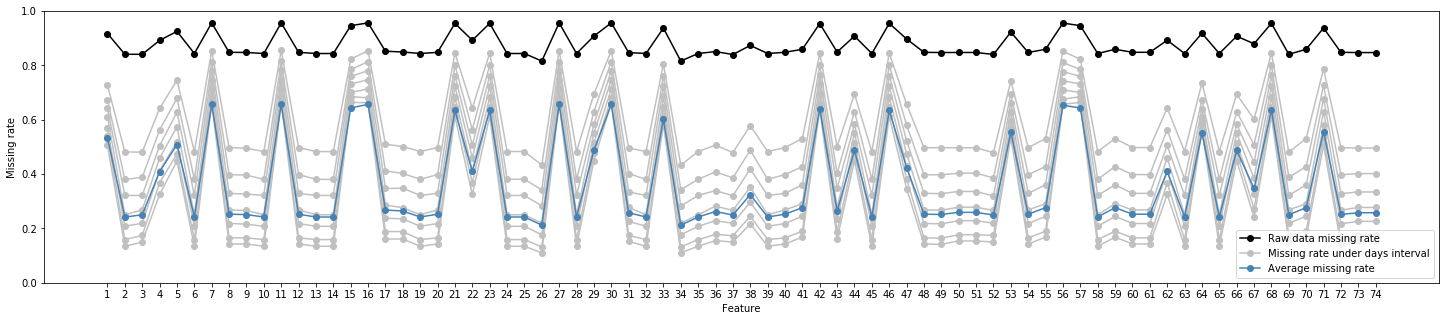

In [324]:
plt.figure(figsize=(25,5))
x=[ i for i in range(1,75)]
plt.plot(x,feature_missing_rate[0],c='black',marker='o',label='Raw data missing rate ')
plt.plot(x,feature_missing_rate[1],c='silver',marker='o')
plt.plot(x,feature_missing_rate[2],c='silver',marker='o')
plt.plot(x,feature_missing_rate[3],c='silver',marker='o')
plt.plot(x,feature_missing_rate[4],c='silver',marker='o')
plt.plot(x,feature_missing_rate[5],c='silver',marker='o')
plt.plot(x,feature_missing_rate[6],c='silver',marker='o')
plt.plot(x,feature_missing_rate[7],c='silver',marker='o',label='Missing rate under days interval')
plt.plot(x,avg_feature_missing_rate,c='steelblue',marker='o',label='Average missing rate')
plt.xlabel('Feature')
plt.ylabel('Missing rate')
plt.gca().set_ylim(0,1)
plt.xticks(x)
plt.legend(loc='lower right')
plt.savefig('feature_missing_rate.jpg', dpi=300)

In [347]:
feature_index=[]
for i in range(len(avg_feature_missing_rate)):
    if (avg_feature_missing_rate[i]<0.35):
        feature_index.append(i)
feature=[o_columns[feature_index[i]] for i in range(len(feature_index))]

In [348]:
feature

['血红蛋白',
 '氯',
 '嗜酸细胞(%)',
 '碱性磷酸酶',
 '白蛋白',
 '嗜碱细胞(%)',
 '总胆红素',
 '血小板计数',
 '单核细胞(%)',
 '间接胆红素',
 'RBC分布宽度CV',
 '中性粒细胞(%)',
 '总蛋白',
 '平均RBC体积',
 '红细胞压积',
 '白细胞计数',
 '平均血红蛋白浓度',
 '尿素',
 '淋巴细胞(#)',
 '红细胞计数',
 '嗜酸细胞(#)',
 '校正钙',
 '钾',
 '葡萄糖',
 '中性粒细胞(#)',
 '直接胆红素',
 '平均PLT体积',
 'RBC分布宽度SD',
 '淋巴细胞(%)',
 '总胆固醇',
 '谷草转氨酶',
 '尿酸',
 '碳酸氢根',
 '钙',
 '乳酸脱氢酶',
 '大血小板比率',
 '单核细胞(#)',
 'PLT分布宽度',
 '球蛋白',
 'γ-谷氨酰转肽酶',
 '嗜碱细胞(#)',
 '平均血红蛋白含量',
 '超敏C反应蛋白',
 '钠',
 '血小板压积',
 '谷丙转氨酶',
 'eGFR(基于CKD-EPI方程)',
 '肌酐']

In [349]:
len(feature)

48

In [350]:
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

def read_data_cn(fname, interval, forecast):
    """
    interval: interval of group data, days
    forecast: whether the patient will die within the next forecast hours
    """

    # read data
    data_df = pd.read_excel(fname, encoding='gbk', index_col=[0])
    # group by interval
    data_df['total_period'] = data_df['出院时间'] - data_df['入院时间']
    data_df['total_period'] = data_df['total_period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['出院时间'] - data_df['RE_DATE']
    data_df['period'] = data_df['period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['total_period'] - data_df['period']
    data_df = data_df.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make outcome
    decease = data_df['出院方式'].values # whether the patient will die in hospital
    data_df['decease'] = decease
    decompensation = data_df['出院时间'] - data_df['RE_DATE'] # whether the patient will die within the next 24 hours
    decompensation = decompensation.apply(lambda x: int(x.total_seconds()/3600 < forecast))
    data_df['decompensation'] = data_df['decease'] * decompensation
    # make it cleaner
    data_df = data_df.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)
    columns = ['PATIENT_ID', 'period','decease', 'decompensation']
    columns.extend(feature)
    data_df = data_df[columns]
    return data_df

In [356]:
interval = 3
forecast = 72
df_train = read_data_cn('data/time_series_375_prerpocess.xlsx', interval, forecast)
# interpolate
df_train = df_train.interpolate(method='linear').ffill().bfill() 

In [357]:
df_train

,PATIENT_ID,period,decease,decompensation,血红蛋白,氯,嗜酸细胞(%),碱性磷酸酶,白蛋白,嗜碱细胞(%),总胆红素,血小板计数,单核细胞(%),间接胆红素,RBC分布宽度CV,中性粒细胞(%),总蛋白,平均RBC体积,红细胞压积,白细胞计数,平均血红蛋白浓度,尿素,淋巴细胞(#),红细胞计数,嗜酸细胞(#),校正钙,钾,葡萄糖,中性粒细胞(#),直接胆红素,平均PLT体积,RBC分布宽度SD,淋巴细胞(%),总胆固醇,谷草转氨酶,尿酸,碳酸氢根,钙,乳酸脱氢酶,大血小板比率,单核细胞(#),PLT分布宽度,球蛋白,γ-谷氨酰转肽酶,嗜碱细胞(#),平均血红蛋白含量,超敏C反应蛋白,钠,血小板压积,谷丙转氨酶,eGFR(基于CKD-EPI方程),肌酐
0,1.0,0.0,0.0,0.0,136.000000,103.10,0.60,46.0,33.30,0.3,8.30,105.000000,10.70,4.3,11.900000,65.800000,69.30,91.800000,39.200000,3.600,347.000000,8.50,0.800000,1.600,0.02,2.29,4.33,7.350000,2.330,4.00,11.90,40.800000,22.600000,3.900,33.0,418.0,21.20,2.020,306.0,39.9,0.380000,16.30,36.00,24.0,0.010000,31.900000,43.10,137.7,0.120,16.0,46.60,130.0
1,1.0,1.0,0.0,0.0,138.000000,102.25,0.45,50.0,33.25,0.2,7.85,159.500000,8.95,4.4,11.750000,66.150000,68.60,91.450000,39.450000,5.250,350.000000,6.75,1.295000,2.980,0.02,2.41,4.53,6.635000,3.455,3.45,11.40,39.900000,24.250000,3.855,34.0,349.5,23.95,2.135,278.0,36.0,0.440000,14.45,35.35,27.5,0.010000,32.000000,23.35,140.3,0.175,29.0,59.65,110.0
2,1.0,2.0,0.0,0.0,140.000000,101.40,0.30,54.0,33.20,0.1,7.40,214.000000,7.20,4.5,11.600000,66.500000,67.90,91.100000,39.700000,6.900,353.000000,5.00,1.790000,4.360,0.02,2.53,4.73,5.920000,4.580,2.90,10.90,39.000000,25.900000,3.810,35.0,281.0,26.70,2.250,250.0,32.1,0.500000,12.60,34.70,31.0,0.010000,32.100000,3.60,142.9,0.230,42.0,72.70,90.0
3,1.0,3.0,0.0,0.0,130.000000,98.50,0.20,57.0,32.40,0.1,16.60,168.000000,4.90,11.1,11.900000,84.300000,62.20,92.700000,38.000000,12.580,342.000000,7.60,1.320000,4.100,0.02,2.33,4.21,17.180000,10.610,5.50,10.50,40.500000,10.500000,3.650,16.0,379.0,25.60,2.040,200.0,29.3,0.620000,11.90,29.80,27.0,0.010000,31.700000,3.10,139.4,0.180,29.0,64.80,99.0
4,1.0,5.0,0.0,0.0,131.000000,100.00,1.70,71.0,37.60,0.2,6.30,141.000000,7.90,3.7,11.900000,64.300000,67.70,93.800000,38.000000,9.670,345.000000,6.50,2.500000,4.050,0.16,2.44,5.15,6.750000,6.230,2.60,11.30,41.500000,25.900000,4.840,23.0,376.0,28.00,2.250,206.0,36.9,0.760000,14.30,30.10,41.0,0.020000,32.300000,2.60,142.7,0.160,30.0,74.70,88.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1162,374.0,1.0,1.0,1.0,121.000000,128.20,0.00,143.0,27.40,0.3,26.00,54.000000,2.90,7.6,12.433333,94.500000,57.50,88.100000,34.700000,14.490,349.000000,18.40,0.330000,3.940,0.00,2.10,4.08,12.970000,13.750,18.40,10.75,37.700000,2.300000,2.790,756.0,458.0,22.00,1.850,1867.0,29.8,0.420000,12.40,30.10,176.0,0.040000,30.700000,61.70,164.7,0.185,1508.0,69.40,118.0
1163,375.0,0.0,1.0,0.0,171.000000,90.30,0.00,70.0,34.20,0.0,8.40,222.000000,6.40,4.0,11.700000,83.700000,72.20,88.200000,47.900000,5.140,357.000000,10.80,0.510000,5.430,0.00,2.29,5.32,15.660000,4.300,4.40,10.70,37.200000,9.900000,5.020,59.0,340.0,19.10,2.030,915.0,29.5,0.330000,12.40,38.00,36.0,0.000000,31.500000,58.50,128.2,0.240,19.0,56.60,114.0
1164,375.0,1.0,1.0,0.0,165.666667,97.50,0.00,76.0,29.75,0.2,15.55,153.666667,4.60,8.4,12.166667,86.366667,61.55,91.166667,47.833333,8.000,346.333333,10.00,0.523333,59.000,0.00,2.28,4.82,14.196667,5.390,7.15,10.70,40.433333,8.833333,4.405,49.0,232.5,21.20,1.920,1083.5,29.5,0.246667,12.40,31.80,37.5,0.016667,31.533333,128.00,135.0,0.240,18.0,70.45,98.0
1165,375.0,2.0,1.0,0.0,160.333333,105.90,0.00,82.0,25.30,0.4,22.70,85.333333,2.80,12.8,12.633333,89.033333,50.90,94.133333,47.766667,8.125,335.666667,9.20,0.536667,31.955,0.00,2.27,4.68,12.733333,6.480,9.90,10.70,43.666667,7.766667,3.790,39.0,125.0,23.30,1.840,1252.0,29.5,0.163333,12.40,25.60,39.0,0.033333,31.566667,197.50,139.9,0.240,17.0,84.30,82.0


In [360]:
creat_batch_data(df_train,'Train_48features')